# 1. Setup and Loading of Data


#### 1.1 Install Dependencies and Setup

In [2]:
import tensorflow as tf
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

#### 1.2 Remove dodgy images

In [4]:
import cv2
import imghdr # to get file extencions

In [5]:
raw_data_dir = "../" + os.path.join('data','raw')
image_exts = ['jpeg','jpg','bmp','png']

In [6]:
os.listdir(os.path.join(raw_data_dir,'happy'))

['7-Habits-of-Happy-People-image 2.jpeg',
 '35438_hd 2.jpg',
 'e162ccda8ce0f197f8863f327add9233.jpg',
 '05-12-21-happy-people.jpg',
 'images4 2.jpg',
 'jumping_for_joy_for_3_kinds_of_happy_people 2.jpg',
 'image22.jpeg',
 'Happy.jpg',
 'goup-happy-people-group-jumping-isolated-white-background-35581971 2.jpg',
 'image22 2.jpeg',
 'smile.woman_ 2.jpg',
 'friends-happy-190821 2.jpg',
 'happy-people-habits 2.jpg',
 '7-principles-of-successful-and-happy-people.png',
 '170404-happy-workers-feature.jpg',
 'MV5BMTM3ODM0NTQ1MF5BMl5BanBnXkFtZTcwMzAxMTM5OA._V1_.jpg',
 'friends-happy-190821.jpg',
 'images25.jpg',
 'happy-people-group-fb 2.jpg',
 'images18 2.jpg',
 'goup-happy-people-group-jumping-isolated-white-background-35582232.jpg',
 '835405 2.jpg',
 'images25 2.jpg',
 'getty_152414899_97046097045006_68075 2.jpg',
 'GettyImages-454356720.jpg',
 'riskshappypeopletakeh_1384254283 2.jpg',
 'VJdvLa-download-happy-blackman-png 2.png',
 'happy-people-13772392.jpg',
 'images18.jpg',
 'happy-indians_

In [7]:
os.listdir(raw_data_dir)

['happy', '.DS_Store', 'sad']

In [8]:
folders =  [f for f in os.listdir(raw_data_dir) if not f.startswith('.')] # avoid including the .DS_Store directory (version control)

In [9]:
folders

['happy', 'sad']

In [10]:
# before running this code, remove all the images below 10KB from the folders
for image_class in folders:
    for image in os.listdir(os.path.join(raw_data_dir,image_class)):
        if not image.startswith('.'):
            image_path = os.path.join(raw_data_dir,image_class,image)

        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print(f'Image not in ext list {image_path}')
                os.remove(image_path)
        except Exception as e:
            print(f'Issue with image {image_path}')
        

#### 1.3 Load Date

In [11]:
import numpy as np 
from matplotlib import pyplot as plt

In [12]:
# build image dataset so no need to build the labels, the classes,... it will do it automatically
data = tf.keras.utils.image_dataset_from_directory(raw_data_dir) 

Found 260 files belonging to 2 classes.
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-11 11:56:00.562666: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-11 11:56:00.562787: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
data_iterator = data.as_numpy_iterator() # allows to loop through the data pipeline

In [14]:
batch = data_iterator.next() # access the data

2023-03-11 11:56:00.662432: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [15]:
# Images represented as numpy arrays
batch[0].shape

(32, 256, 256, 3)

In [16]:
batch[1] # the label (eighter happy or sad)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 0], dtype=int32)

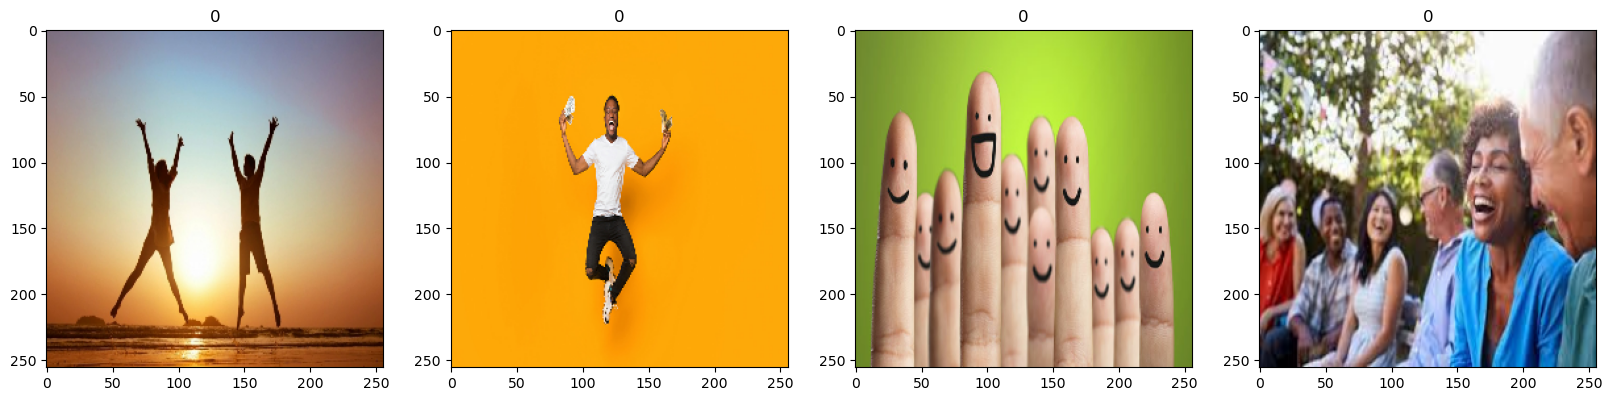

In [17]:
# identify which label value belongs to which class
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].set_title(batch[1][idx])

In [18]:
# CLASS 1 = SAD PEOPLE
# CLASS 0 = HAPPY PEOPLE

# 2, Preprocess Data

#### 2.1 Scale Data

In [19]:
# help model generalize faster and produce better results by scaling image values between 0-1 instead of 0-255
# split between train, test and validation to ensure we don't overfit

In [20]:
data = data.map(lambda x,y: (x/255,y))

In [21]:
scaled_iterator = data.as_numpy_iterator()

In [22]:
batch = scaled_iterator.next()

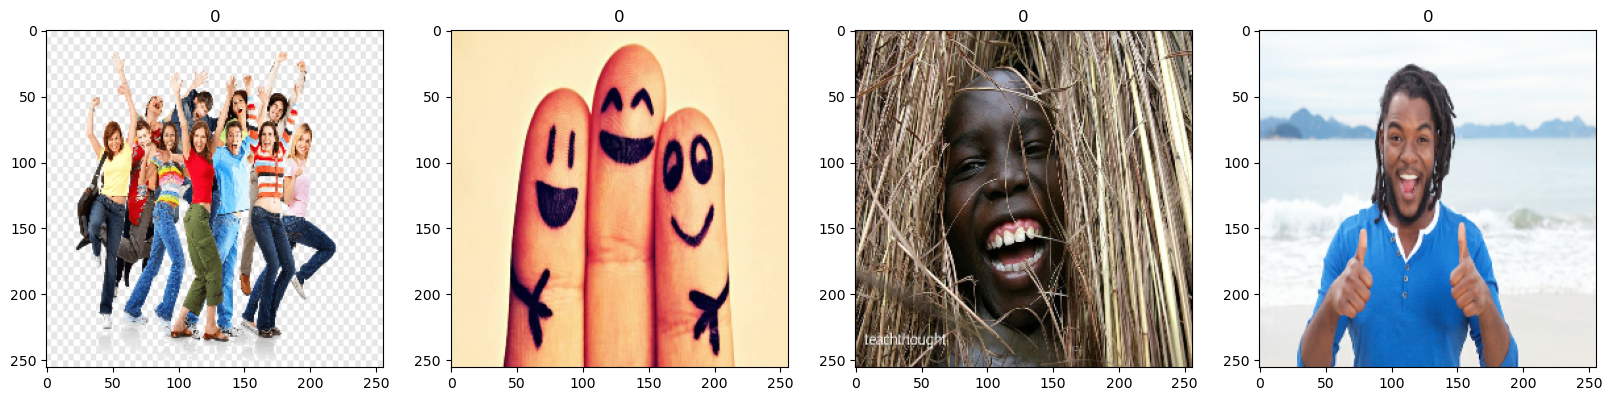

In [23]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].set_title(batch[1][idx])

In [24]:
batch[0].max()

1.0

#### 2.2 Split Data

In [25]:
round(len(data)) # (number of batches)

9

In [26]:
train_size = round(len(data)*0.7) # to train
val_size = round(len(data)*0.2) # to evaluate the model while training (fine tuuning)
test_size = round(len(data)*0.1) # to test (at the end)

In [27]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 3. Deep Model

#### 3.1 Build Deep Learning Model

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [29]:
model = Sequential() # initialize instance of sequential class

In [30]:
# 3 convolution layer, a flat layer and a dense layer
model.add(Conv2D(16,(3,3),1,activation="relu",input_shape=(256,256,3))) # first layer need to have an input or is an input layer 
# 16 filters of size 3x3 pixels and stride of 1 (relu allows to take non linearity)
model.add(MaxPooling2D()) # condence information by returning max value of 2x2 regions

model.add(Conv2D(32,(3,3),1,activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten()) 

model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

In [31]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy']) # adam is the optimilizer we choose

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

#### 3.2 Train

In [33]:
logdir = '../logs'

In [34]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) # usefull to save model at certain point or make logs

In [35]:
hist = model.fit(train,epochs=20,validation_data=val,callbacks=[tensorboard_callback], verbose=2)

Epoch 1/20


2023-03-11 11:56:05.879105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-11 11:56:08.493237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 - 5s - loss: 0.8677 - accuracy: 0.6250 - val_loss: 0.4739 - val_accuracy: 0.7812 - 5s/epoch - 791ms/step
Epoch 2/20
6/6 - 4s - loss: 0.5183 - accuracy: 0.7188 - val_loss: 0.5314 - val_accuracy: 0.6875 - 4s/epoch - 697ms/step
Epoch 3/20
6/6 - 4s - loss: 0.4824 - accuracy: 0.7448 - val_loss: 0.4673 - val_accuracy: 0.7344 - 4s/epoch - 696ms/step
Epoch 4/20
6/6 - 4s - loss: 0.4147 - accuracy: 0.7812 - val_loss: 0.3451 - val_accuracy: 0.8281 - 4s/epoch - 699ms/step
Epoch 5/20
6/6 - 4s - loss: 0.3644 - accuracy: 0.8229 - val_loss: 0.2178 - val_accuracy: 0.8594 - 4s/epoch - 699ms/step
Epoch 6/20
6/6 - 4s - loss: 0.3072 - accuracy: 0.8646 - val_loss: 0.2483 - val_accuracy: 0.9375 - 4s/epoch - 694ms/step
Epoch 7/20
6/6 - 4s - loss: 0.2174 - accuracy: 0.9323 - val_loss: 0.1221 - val_accuracy: 0.9688 - 4s/epoch - 694ms/step
Epoch 8/20
6/6 - 4s - loss: 0.1523 - accuracy: 0.9427 - val_loss: 0.2280 - val_accuracy: 0.9688 - 4s/epoch - 694ms/step
Epoch 9/20
6/6 - 4s - loss: 0.1873 - accuracy: 0.96

#### 3.3 Plot Performance

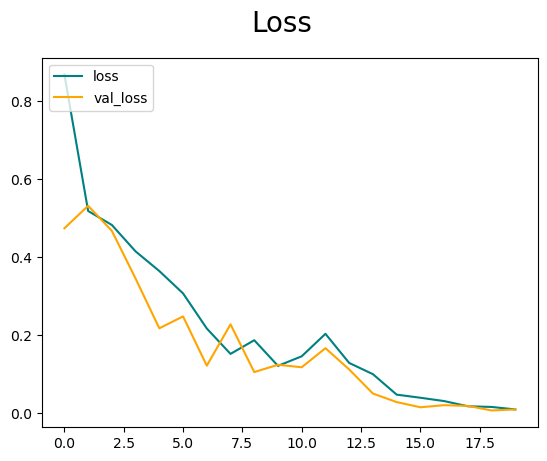

In [36]:
fig = plt.figure()
plt.plot(hist.history["loss"], color='teal',label='loss')
plt.plot(hist.history["val_loss"], color='orange',label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

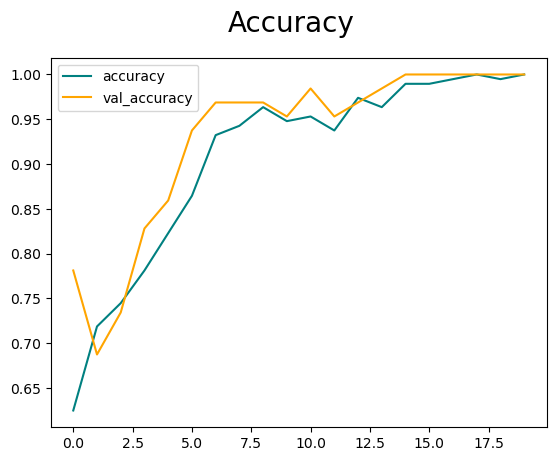

In [37]:
fig = plt.figure()
plt.plot(hist.history["accuracy"], color='teal',label='accuracy')
plt.plot(hist.history["val_accuracy"], color='orange',label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

# 4. Evaluate Performance

#### 4.1 Evaluate

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy # metrics for classification

In [39]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X) # make predictions now instead of training (fit)
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    acc.update_state(y,yhat)

1/1 [==============================] - 0s 96ms/step


2023-03-11 11:57:32.517960: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [41]:
print(f"Precision: {pre.result().numpy()}, Recall: {re.result().numpy()}, Accuracy: {acc.result().numpy()}")

Precision: 1.0, Recall: 1.0, Accuracy: 1.0


#### 4.2 Test

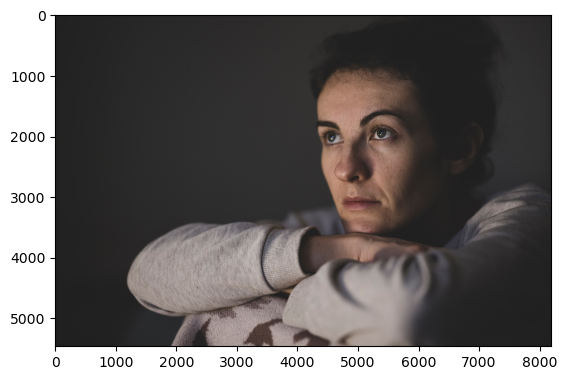

In [60]:
img = cv2.imread('../imgsad.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()


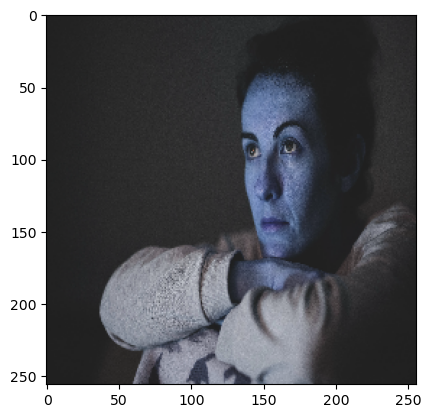

In [61]:
resize = tf.image.resize(img,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [62]:
yhat = model.predict(np.expand_dims(resize/255,0)) #

1/1 [==============================] - 0s 18ms/step


In [63]:
yhat

array([[0.9738104]], dtype=float32)

In [64]:
if yhat > 0.5:
    print('Predicted class is Sad')
else:
    print('Predicted class is Happy')

Predicted class is Sad


# 5. Save the Model

#### 5.1 Save the Model

In [65]:
from tensorflow.keras.models import load_model

In [67]:
model.save(os.path.join('../models','happysadmodel.h5'))

In [69]:
new_model = load_model(os.path.join('..','models','happysadmodel.h5'))

In [70]:
new_model

In [72]:
yhat_new = new_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 15ms/step


In [73]:
if yhat > 0.5:
    print('Predicted class is Sad')
else:
    print('Predicted class is Happy')

Predicted class is Sad
